<a href="https://colab.research.google.com/github/LuZhang0128/CompLegFall2019/blob/master/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [ ]:
!pip install -U git+http://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git --quiet
!pip install NRCLex --quiet
!pip install -U kaleido --quiet
!pip install transformers --quiet
!pip install imbalanced-learn --quiet
import urllib.request
import imblearn 
from imblearn.over_sampling import SMOTE
import pandas as pd 
import re 
import csv
import nltk 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import wordcloud
import spacy
import gensim
import numpy as np 
import seaborn as sns
import datetime as dt
import math
import sklearn
import sklearn.metrics.pairwise 
import sklearn.manifold 
import sklearn.decomposition 
import sklearn.feature_extraction.text
import sklearn.feature_extraction
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, r2_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
import lucem_illud
from lucem_illud.processing import normalizeTokens, trainTestSplit, word_tokenize, sent_tokenize
from nrclex import NRCLex
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax

nltk.download('punkt')

%matplotlib inline

     |████████████████████████████████| 5.6 MB 8.8 MB/s 
     |████████████████████████████████| 117 kB 47.9 MB/s 
     |████████████████████████████████| 181 kB 23.6 MB/s 
     |████████████████████████████████| 76 kB 5.4 MB/s 
     |████████████████████████████████| 132 kB 5.3 MB/s 
     |████████████████████████████████| 32.8 MB 95 kB/s 
     |████████████████████████████████| 79 kB 5.3 MB/s 
     |████████████████████████████████| 8.8 MB 44.9 MB/s 
     |████████████████████████████████| 138 kB 53.4 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 5.1 MB 45.0 MB/s 
     |████████████████████████████████| 127 kB 50.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 396 kB

In [ ]:
# current package dependencies
!pip list -v 

Package                       Version                        Location                               Installer
----------------------------- ------------------------------ -------------------------------------- ---------
absl-py                       1.0.0                          /usr/local/lib/python3.7/dist-packages pip
alabaster                     0.7.12                         /usr/local/lib/python3.7/dist-packages pip
albumentations                0.1.12                         /usr/local/lib/python3.7/dist-packages pip
altair                        4.2.0                          /usr/local/lib/python3.7/dist-packages pip
appdirs                       1.4.4                          /usr/local/lib/python3.7/dist-packages pip
argon2-cffi                   21.3.0                         /usr/local/lib/python3.7/dist-packages pip
argon2-cffi-bindings          21.2.0                         /usr/local/lib/python3.7/dist-packages pip
arviz                         0.12.1                

# Load and Clean Data
Here I've collaborated with my friend and have written a scraper for Twitter data. However, it only randomly send back a certain amount of Tweets per day every time I try to make request through the code. Here for this class project, I just used one output file, and can expand the scale by running the program multiple times. 

In [ ]:
from google.colab import drive
# please go to the google drive link, and save the data folder to your own google drive to run the code
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# read in data from several different requests
df1 = pd.read_csv('/content/drive/MyDrive/Perspectives/data/twitter_info_reply1.csv')
df = df1.drop_duplicates().reset_index(drop=True)

In [ ]:
# remove urls and uninformative information like websites and '@'s
cleaned_text = []
for row in df['m_content']:
    text = str(row)
    text = re.sub(r'https?://\S+|www\.\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\B[@]\S+\b', '', text)
    cleaned_text.append(text)

df['text'] = cleaned_text
df['g_publish_time']= pd.to_datetime(df['g_publish_time'])
df = df.dropna(subset=['text'])

In [ ]:
print(len(df))
df.head()

123517


,m_content,m_content_url,m_content_id,m_images,m_videos,r_comment_num,g_publish_time,r_like_num,r_trans_num,u_id,keyword,in_reply_to_screen_name,in_reply_to_status_id,u_nickname,u_area,screen_name,text
0,http://twitpic.com/gh4w - Wolf-dieter ring #blm,https://twitter.com/jbenno/status/962079197,962079197,NaN,NaN,0,2008-10-16,0,0,10177792,BLM,NaN,None,Joerg Blumtritt,Abu Dhabi,jbenno,- Wolf-dieter ring #blm
1,http://twitpic.com/gh3o - Hier @presseschauer ...,https://twitter.com/jbenno/status/962066767,962066767,NaN,NaN,0,2008-10-16,0,0,10177792,BLM,NaN,None,Joerg Blumtritt,Abu Dhabi,jbenno,- Hier und #blm
2,@furukama the leagel dabate on trust and commu...,https://twitter.com/jbenno/status/962226263,962226263,NaN,NaN,0,2008-10-16,0,0,10177792,BLM,furukama,962226263,Joerg Blumtritt,Abu Dhabi,jbenno,the leagel dabate on trust and communications...
3,http://twitpic.com/gno2 - Noshow-tisch #blm,https://twitter.com/jbenno/status/963782003,963782003,NaN,NaN,0,2008-10-17,0,0,10177792,BLM,NaN,None,Joerg Blumtritt,Abu Dhabi,jbenno,- Noshow-tisch #blm
4,http://twitpic.com/gno6 - Buffet #blm,https://twitter.com/jbenno/status/963782458,963782458,NaN,NaN,0,2008-10-17,0,0,10177792,BLM,NaN,None,Joerg Blumtritt,Abu Dhabi,jbenno,- Buffet #blm


In [ ]:
# split the data to before the event and after the event
# before is 0 and after is 1
before = []
for i in df.iloc:
  # print(i.g_publish_time)
  # print(i.g_publish_time < pd.to_datetime('2020-05-25'))
  if i.g_publish_time < pd.to_datetime('2020-05-25'):
    before.append(0)
  else:
    before.append(1)

df['target'] = before

KeyboardInterrupt: ignored

In [ ]:
# create tokens for future use
df['tokenized_text'] = df['text'].apply(lambda x: word_tokenize(x))
df['normalized_text'] = df['tokenized_text'].apply(lambda x: normalizeTokens(x))

In [ ]:
df['tokenized_sents'] = df['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
df['normalized_sents'] = df['tokenized_sents'].apply(lambda x: [normalizeTokens(s) for s in x])

In [ ]:
# save the data
df.to_csv('/content/drive/MyDrive/Perspectives/df.csv')
df.to_pickle('/content/drive/MyDrive/Perspectives/df.pkl')

In [ ]:
# read in the data
df = pd.read_csv('/content/drive/MyDrive/BLM_data/df.csv')

# Basic Plots

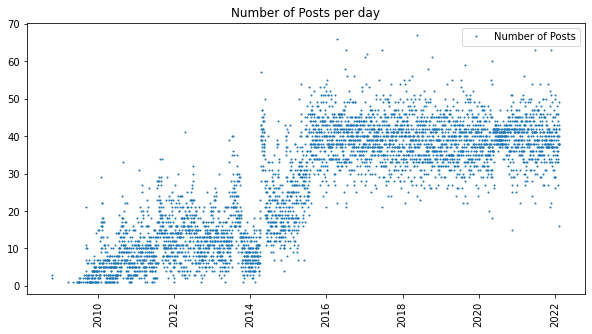

In [ ]:
# number of posts per day
df_gb = df.groupby(['g_publish_time']).size()

plt.figure(figsize=(10,5))
plt.plot(df_gb, 'o',label="Number of Posts", markersize=1, linewidth=0.1)
plt.xticks(rotation=90)
plt.title("Number of Posts per day")
plt.legend()
plt.show()

## Word Cloud

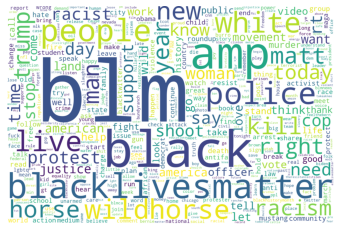

In [ ]:
# overall word cloud
wc = wordcloud.WordCloud(background_color="white", max_words=500, width=3000, height=2000, mode='RGBA', collocations=False, scale=.5).generate(' '.join(df['normalized_text'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("#BLM Tweets.pdf", format = 'pdf')

In [ ]:
# create seperate dataset for before and after the event
df_before = df[df["target"]==0]
df_after = df[df["target"]==1]

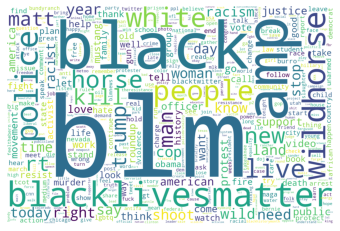

In [ ]:
# word cloud before the event
wc = wordcloud.WordCloud(background_color="white", max_words=500, width=3000, height=2000, mode='RGBA', collocations=False, scale=.5).generate(' '.join(df_before['normalized_text'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("#BLM Tweets before 2020-05-25.pdf", format = 'pdf')

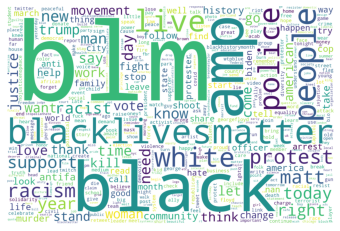

In [ ]:
# word cloud after the event
wc = wordcloud.WordCloud(background_color="white", max_words=500, width=3000, height=2000, mode='RGBA', collocations=False, scale=.5).generate(' '.join(df_after['normalized_text'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("#BLM Tweets after 2020-05-25.pdf", format = 'pdf')

# Pre-trained BERT model for Emotion Classification

In [ ]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [ ]:
# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='emotion'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

Downloading:   0%|          | 0.00/768 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

In [ ]:
from scipy.special.orthogonal import jacobi
sent = df['text']

joy = []
optimism = []
anger = []
sadness = []

# j = 0

for sent_text in sent:
  # print(j)
  sent_text = preprocess(sent_text)
  encoded_input = tokenizer(sent_text, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)  

  ranking = np.argsort(scores)
  ranking = ranking[::-1]
  for i in range(scores.shape[0]):
      l = labels[ranking[i]]
      s = scores[ranking[i]]

      if l=='joy':
        joy.append(s)
      elif l=='optimism':
        optimism.append(s)
      elif l=='anger':
        anger.append(s)
      elif l=='sadness':
        sadness.append(s)

  # j += 1

In [ ]:
df['joy'] = joy
df['optimism'] = optimism
df['anger'] = anger
df['sadness'] = sadness

In [ ]:
# save the data
# df.to_csv('/content/drive/MyDrive/Perspectives/df_emotion.csv')
# df.to_pickle('/content/drive/MyDrive/Perspectives/df_emotion.pkl')

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/Perspectives/df_emotion.pkl')

In [ ]:
mean_joy = df.groupby('g_publish_time')['joy'].mean().reset_index()
mean_optimism = df.groupby('g_publish_time')['optimism'].mean().reset_index()
mean_anger = df.groupby('g_publish_time')['anger'].mean().reset_index()
mean_sadness = df.groupby('g_publish_time')['sadness'].mean().reset_index()

In [ ]:
mean_joy.loc[mean_joy['g_publish_time'] == '2016-01-01']

In [ ]:
mean_joy.loc[mean_joy['g_publish_time'] == '2020-05-25']

In [ ]:
# plot average joy score with low alpha value
plt.scatter(mean_joy['g_publish_time'], mean_joy['joy'], c = 'grey', alpha = 0.05)

# convert date to numerical values
mean_joy['g_publish_time'] = pd.to_datetime(mean_joy['g_publish_time'])
mean_joy['g_publish_time']=mean_joy['g_publish_time'].map(dt.datetime.toordinal)

# linear regression before and after the event
x1 = mean_joy['g_publish_time'][2269:3875]
y1 = mean_joy['joy'][2269:3875]
m1,b1 = np.polyfit(x1, y1, 1)
plt.plot(x1, m1*x1 + b1,'--', label='2016/01/01 - Event', linewidth=2, c = 'tab:blue')

from sklearn.metrics import r2_score
print(r2_score(y1, m1*x1+b1))

x2 = mean_joy['g_publish_time'][3875:]
y2 = mean_joy['joy'][3875:]
m2,b2 = np.polyfit(x2, y2, 1)
plt.plot(x2, m2*x2 + b2,'--', label='Event - 2022/02/15', linewidth=2, c = 'tab:orange')

print(r2_score(y2, m2*x2+b2))

# plot
plt.xlabel("Date")
plt.ylabel("Average Joy Score")
plt.legend(loc = 'upper right')
plt.title('Average Joy Score per Day',fontweight ='bold',size=14)
plt.savefig('Average Joy Score per Day')
plt.show()

print(m1,m2)

In [ ]:
# plot average optimism score with low alpha value
plt.scatter(mean_optimism['g_publish_time'], mean_optimism['optimism'], c = 'grey', alpha = 0.05)

# convert date to numerical values
mean_optimism['g_publish_time'] = pd.to_datetime(mean_optimism['g_publish_time'])
mean_optimism['g_publish_time']=mean_optimism['g_publish_time'].map(dt.datetime.toordinal)

# linear regression before and after the event
x1 = mean_optimism['g_publish_time'][2269:3875]
y1 = mean_optimism['optimism'][2269:3875]
m1,b1 = np.polyfit(x1, y1, 1)
plt.plot(x1, m1*x1 + b1,'--', label='2016/01/01 - Event', linewidth=2, c = 'tab:blue')

x2 = mean_optimism['g_publish_time'][3875:]
y2 = mean_optimism['optimism'][3875:]
m2,b2 = np.polyfit(x2, y2, 1)
plt.plot(x2, m2*x2 + b2,'--', label='Event - 2022/02/15', linewidth=2, c = 'tab:orange')

# plot
plt.xlabel("Date")
plt.ylabel("Average Optimism Score")
plt.legend(loc = 'upper right')
plt.title('Average Optimism Score per Day',fontweight ='bold',size=14)
plt.savefig('Average Optimism Score per Day')
plt.show()

In [ ]:
# plot average anger score with low alpha value
plt.scatter(mean_anger['g_publish_time'], mean_anger['anger'], c = 'grey', alpha = 0.05)

# convert date to numerical values
mean_anger['g_publish_time'] = pd.to_datetime(mean_anger['g_publish_time'])
mean_anger['g_publish_time']=mean_anger['g_publish_time'].map(dt.datetime.toordinal)

# linear regression before and after the event
x1 = mean_anger['g_publish_time'][2269:3875]
y1 = mean_anger['anger'][2269:3875]
m1,b1 = np.polyfit(x1, y1, 1)
plt.plot(x1, m1*x1 + b1,'--', label='2016/01/01 - Event', linewidth=2, c = 'tab:blue')

x2 = mean_anger['g_publish_time'][3875:]
y2 = mean_anger['anger'][3875:]
m2,b2 = np.polyfit(x2, y2, 1)
plt.plot(x2, m2*x2 + b2,'--', label='Event - 2022/02/15', linewidth=2, c = 'tab:orange')

# plot
plt.xlabel("Date")
plt.ylabel("Average Anger Score")
plt.legend(loc = 'upper right')
plt.title('Average Anger Score per Day',fontweight ='bold',size=14)
plt.savefig('Average Anger Score per Day')
plt.show()

In [ ]:
# plot average sadness score with low alpha value
plt.scatter(mean_sadness['g_publish_time'], mean_sadness['sadness'], c = 'grey', alpha = 0.05)

# convert date to numerical values
mean_sadness['g_publish_time'] = pd.to_datetime(mean_sadness['g_publish_time'])
mean_sadness['g_publish_time']=mean_sadness['g_publish_time'].map(dt.datetime.toordinal)

# linear regression before and after the event
x1 = mean_sadness['g_publish_time'][2269:3875]
y1 = mean_sadness['sadness'][2269:3875]
m1,b1 = np.polyfit(x1, y1, 1)
plt.plot(x1, m1*x1 + b1,'--', label='2016/01/01 - Event', linewidth=2, c = 'tab:blue')

x2 = mean_sadness['g_publish_time'][3875:]
y2 = mean_sadness['sadness'][3875:]
m2,b2 = np.polyfit(x2, y2, 1)
plt.plot(x2, m2*x2 + b2,'--', label='Event - 2022/02/15', linewidth=2, c = 'tab:orange')

# plot
plt.xlabel("Date")
plt.ylabel("Average Sadness Score")
plt.legend(loc = 'upper right')
plt.title('Average Sadness Score per Day',fontweight ='bold',size=14)
plt.savefig('Average Sadness Score per Day')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X = x1
y = y1

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

# Machine Learning Model


## import and clean data

In [ ]:
# import the manual label of Twitter accounts
label = pd.read_csv('/content/drive/MyDrive/Perspectives/data/Perspectives_Labelling.csv').iloc[:, [0,8]]
label = label.loc[label["number"] != -1]

In [ ]:
label 

,account,number
0,jbenno,4
1,keith_bloke,4
2,society08085469,4
3,ResmaaMenakem,3
4,AmyJNobles,3
...,...,...
475,SWPDUB,4
476,DiametricSlant,4
477,FindingKJMovie,1
478,WArthurJ1,3


In [ ]:
# merge and select tweets with labeled accounts
labeled_df = df.merge(label, left_on='screen_name', right_on='account', how='inner')

In [ ]:
# use Tf-Idf to vectorize the tweet text
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=1000, min_df=2, stop_words='english', norm='l2')

# split training and testing sets
X_train, X_test, y_train, y_test = train_test_split(labeled_df['text'], labeled_df['number'], test_size=0.3, random_state=42)

# fit and transform on training set
X_train = TFVectorizer.fit_transform(X_train)
# transform on testing set
X_test = TFVectorizer.transform(X_test)

In [ ]:
# use SMOTE method to oversample the minority classes, and balance the imbalanced dataset
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
X_train.shape

(5096, 4467)

## Random Forest

In [ ]:
# random forest classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
parameters = {'n_estimators': [1, 10, 50, 100, 200],
              'criterion': ['gini', 'entropy'],
              'max_depth': [1, 2, 5, 10, 20, 50, None]}

grid_cv = GridSearchCV(estimator=rf, param_grid=parameters, cv=10)

grid_cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 5, 10, 20, 50, None],
                         'n_estimators': [1, 10, 50, 100, 200]})

In [ ]:
grid_cv.best_params_

{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 200}

In [ ]:
rf = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=None, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=200, random_state=42)

In [ ]:
print(f"Training score is: {rf.score(X_train, y_train)}")
print(f"Testing score is: {rf.score(X_test, y_test)}")

Training score is: 0.9848901098901099
Testing score is: 0.7429906542056075


## Logistic Regression

In [ ]:
# logistic regression
lr = LogisticRegression(random_state=42)
parameters = {'penalty': ['l1', 'l2'],
              'C': [0.01, 0.1, 1, 10, 100, 200],
              'solver': ['liblinear']}

grid_cv = GridSearchCV(estimator=lr, param_grid=parameters, cv=10)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 200],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

In [ ]:
grid_cv.best_params_

{'C': 200, 'penalty': 'l2', 'solver': 'liblinear'}

In [ ]:
lr = LogisticRegression(C=200, penalty='l2', solver='liblinear', random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(C=200, random_state=42, solver='liblinear')

In [ ]:
print(f"Training score is: {lr.score(X_train, y_train)}")
print(f"Testing score is: {lr.score(X_test, y_test)}")

Training score is: 0.9752747252747253
Testing score is: 0.7065420560747664


## SVM

In [ ]:
# SVC
svm = SVC(random_state=42)
parameters = {'C': [0.01, 0.1, 1, 10, 100],
              'kernel': ['poly', 'rbf', 'sigmoid'],
              'gamma': [1, 0.1, 0.01, 0.001]}

grid = GridSearchCV(estimator=svm, param_grid=parameters, cv=10)

grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVC(random_state=42),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['poly', 'rbf', 'sigmoid']})

In [ ]:
grid.best_estimator_

SVC(C=10, gamma=1, random_state=42)

In [ ]:
svm = SVC(C=10, gamma=1, random_state=42)
svm.fit(X_train, y_train)

SVC(C=10, gamma=1, random_state=42)

In [ ]:
print(f"Training score is: {svm.score(X_train, y_train)}")
print(f"Testing score is: {svm.score(X_test, y_test)}")

Training score is: 0.9676216640502355
Testing score is: 0.7317757009345794


## MultinomialNB

In [ ]:
# MultinomialNB
mnb = MultinomialNB()
parameters = {'alpha': [0.5, 1.0, 1.5, 2, 5, 10, 20],
              'fit_prior': [True, False],  
}

grid = GridSearchCV(estimator=mnb, param_grid=parameters, cv=10)

grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=MultinomialNB(),
             param_grid={'alpha': [0.5, 1.0, 1.5, 2, 5, 10, 20],
                         'fit_prior': [True, False]})

In [ ]:
grid.best_estimator_

MultinomialNB(alpha=0.5)

In [ ]:
mnb = MultinomialNB(alpha=0.5, fit_prior=False)
mnb.fit(X_train, y_train)

MultinomialNB(alpha=0.5, fit_prior=False)

In [ ]:
print(f"Training score is: {mnb.score(X_train, y_train)}")
print(f"Testing score is: {mnb.score(X_test, y_test)}")

Training score is: 0.9309262166405023
Testing score is: 0.6934579439252336


## Models' Evaluation

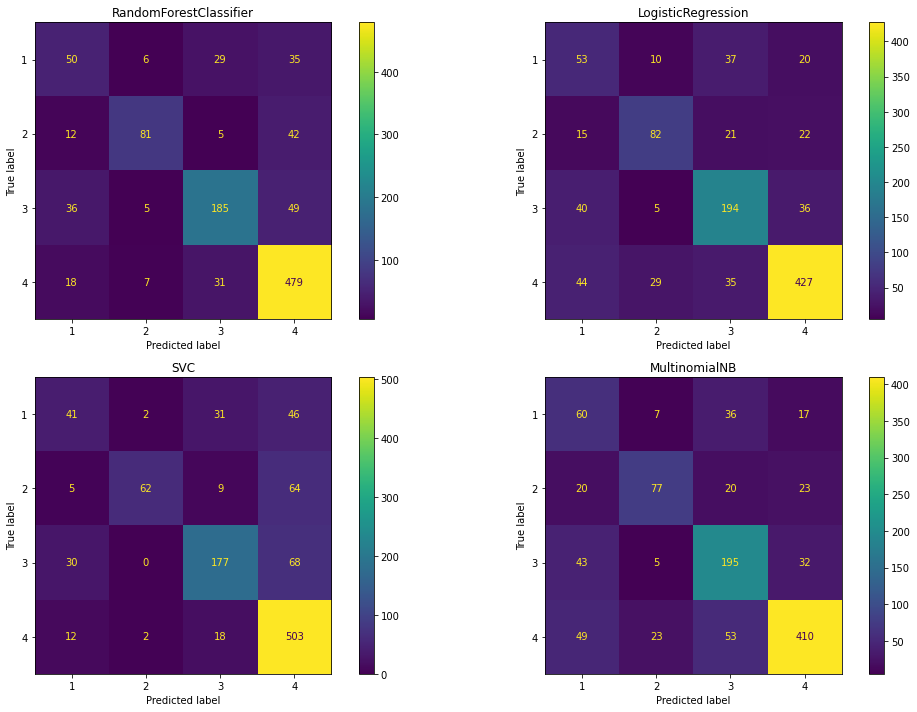

In [ ]:
# plot the confusion matricies
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

classifiers = [rf, lr, svm, mnb]

count = 0
for cls, ax in zip(classifiers, axes.flatten()):
    if count == len(classifiers):
        break

    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax)
    ax.title.set_text(type(cls).__name__)
    count += 1
plt.tight_layout()  
plt.savefig('confusion_matricies')
plt.show()

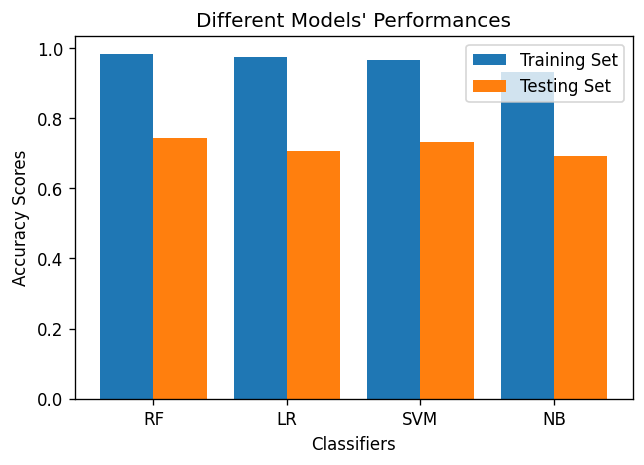

In [ ]:
# plot the accuracy scores for the training and testing sets
import matplotlib.pyplot as plt

scores_train = [rf.score(X_train, y_train), lr.score(X_train, y_train), svm.score(X_train, y_train), mnb.score(X_train, y_train)]
scores_test = [rf.score(X_test, y_test), lr.score(X_test, y_test), svm.score(X_test, y_test), mnb.score(X_test, y_test)]
X = ['RF', 'LR', 'SVM', 'NB']

X_axis = np.arange(len(X))

plt.figure(dpi = 120)
plt.bar(X_axis - 0.2, scores_train, 0.4, label="Training Set")
plt.bar(X_axis + 0.2, scores_test, 0.4, label="Testing Set")
plt.xticks(X_axis, X)
plt.title("Different Models' Performances")
plt.xlabel('Classifiers')
plt.ylabel('Accuracy Scores')
plt.legend()
plt.savefig('accuracy')

# Popularity and Emotion

In [ ]:
df[df['g_publish_time']=='2016-01-01']

,m_content,m_content_url,m_content_id,m_images,m_videos,r_comment_num,g_publish_time,r_like_num,r_trans_num,u_id,...,in_reply_to_screen_name,in_reply_to_status_id,u_nickname,u_area,screen_name,text,joy,optimism,anger,sadness
35798,My call 2 @JolietPolice reporting hate crime O...,https://twitter.com/cgrapski/status/6826059630...,682605963011043328,NaN,NaN,3,2016-01-01,1,4,64579004,...,NaN,None,Charles Grapski,"Kissimmee, FL, USA",cgrapski,My call 2 reporting hate crime Officer Michae...,0.004721,0.013814,0.960144,0.021322
35803,Brilliant political cartoonist @LatuffCartoons...,https://twitter.com/MikePrysner/status/6826240...,682624095498940417,['http://pbs.twimg.com/media/CXkq_qQWsAAeKcd.j...,NaN,0,2016-01-01,41,52,309302492,...,NaN,None,#ShutDownRedHill,NaN,MikePrysner,Brilliant political cartoonist nails it again,0.695922,0.042135,0.241821,0.020122
35804,Looking fwd to continued #UNITY in 2016. #BLM ...,https://twitter.com/Anony_Witch/status/6825935...,682593530968158208,['http://pbs.twimg.com/media/CXkPMwAWsAAWpjJ.j...,NaN,1,2016-01-01,7,8,4366851977,...,NaN,None,AnonyWitch™,Oz,Anony_Witch,Looking fwd to continued #UNITY in 2016. #BLM ...,0.067310,0.763981,0.135727,0.032981
35806,"#BLM,#TamirRice,2016,Gregorian calendar give m...",https://twitter.com/BlakUnited/status/68260198...,682601988266278912,['http://pbs.twimg.com/media/CXkW4YSUwAEPrNu.j...,NaN,0,2016-01-01,1,1,991126873,...,NaN,None,Thoughttravel24bpersecond,United States,BlakUnited,"#BLM,#TamirRice,2016,Gregorian calendar give m...",0.076151,0.361911,0.336415,0.225523
35809,#feeltheBern #TamirRice #BLM Can't accept lie-...,https://twitter.com/JodyCoyote12/status/682693...,682693102809800705,['http://pbs.twimg.com/media/CXlpwnKWwAAAE4F.j...,NaN,0,2016-01-01,1,0,3433416514,...,NaN,None,#FreeJulianAssange,bosco prato foresta,JodyCoyote12,#feeltheBern #TamirRice #BLM Can't accept lie-...,0.004694,0.024041,0.953902,0.017362
35813,This editorial cartoon featured in Harper's We...,https://twitter.com/phemale61/status/682697473...,682697473899540484,['http://pbs.twimg.com/media/CXltvBvUoAAPxzx.j...,NaN,1,2016-01-01,6,5,207141071,...,NaN,None,Terrible Terry,NaN,phemale61,This editorial cartoon featured in Harper's We...,0.093520,0.167440,0.479580,0.259459
35814,Internal doc dump showing #LaquanMcDonald coor...,https://twitter.com/CAARPRNow/status/682706661...,682706661576937472,NaN,NaN,0,2016-01-01,8,17,1377947881,...,NaN,None,The Chicago Alliance,Chicago,CAARPRNow,Internal doc dump showing #LaquanMcDonald coor...,0.033658,0.067524,0.369690,0.529129
35816,#Resolve to be a #wildland #firefighter with #...,https://twitter.com/BLMIdahoFire/status/682608...,682608521645584384,['http://pbs.twimg.com/media/CXkc1UOW8AE2tsB.j...,NaN,0,2016-01-01,0,1,349150443,...,NaN,None,Bureau of Land Management Idaho Fire,"Boise, Idaho",BLMIdahoFire,#Resolve to be a #wildland #firefighter with #...,0.208625,0.631041,0.086745,0.073590
35819,Dear Black Folks: A Love Letter from a White W...,https://twitter.com/Xpressionable/status/68271...,682712121596112896,NaN,NaN,0,2016-01-01,1,2,532291506,...,NaN,None,Xpressionable,NaN,Xpressionable,Dear Black Folks: A Love Letter from a White W...,0.836538,0.086933,0.022137,0.054392
35820,LZ Granderson on #BLM: ‘The Important Thing Is...,https://twitter.com/ATLBlackStar/status/682607...,682607622810419205,['http://pbs.twimg.com/media/CXkcBCgW8AAi_HC.j...,NaN,0,2016-01-01,0,2,565521611,...,NaN,None,Atlanta Black Star,"Atlanta, GA",ATLBlackStar,LZ Granderson on #BLM: ‘The Important Thing Is...,0.184713,0.661138,0.090333,0.063816


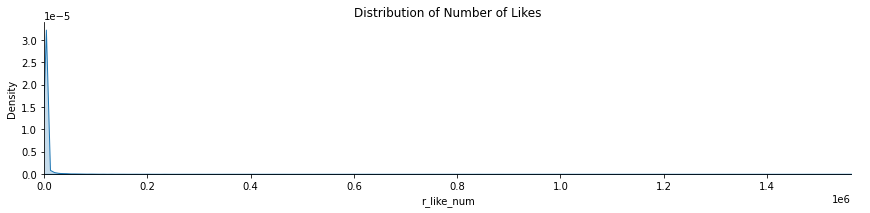

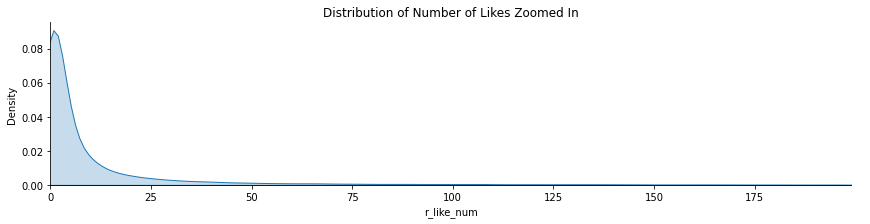

In [ ]:
facet = sns.FacetGrid(df, aspect=4)
facet.map(sns.kdeplot,'r_like_num',shade=True)
facet.set(xlim=(0, df['r_like_num'].max()))
facet.set(title="Distribution of Number of Likes")
facet.add_legend()
plt.show()

like_sampled = df[df['r_like_num']<200]
facet = sns.FacetGrid(like_sampled, aspect=4)
facet.map(sns.kdeplot,'r_like_num',shade=True)
facet.set(xlim=(0, like_sampled['r_like_num'].max()))
facet.set(title="Distribution of Number of Likes Zoomed In")
facet.add_legend()
plt.show()

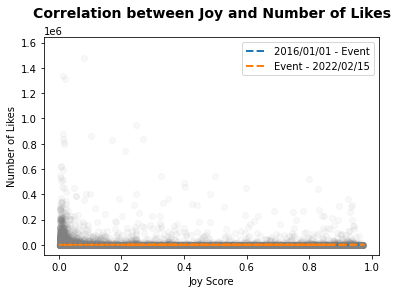

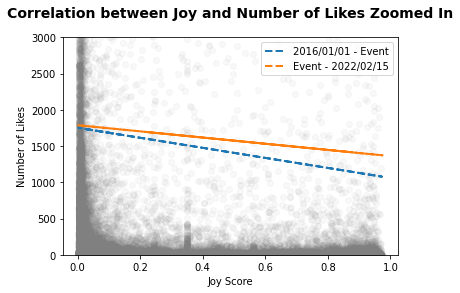

In [ ]:
# plot average joy score with low alpha value
plt.scatter(df['joy'], df['r_like_num'], c = 'grey', alpha = 0.05)
# linear regression before and after the event
x1 = df['joy'][35833:98520]
y1 = df['r_like_num'][35833:98520]
m1,b1 = np.polyfit(x1, y1, 1)
plt.plot(x1, m1*x1 + b1,'--', label='2016/01/01 - Event', linewidth=2, c = 'tab:blue')
x2 = df['joy'][98520:]
y2 = df['r_like_num'][98520:]
m2,b2 = np.polyfit(x2, y2, 1)
plt.plot(x2, m2*x2 + b2,'--', label='Event - 2022/02/15', linewidth=2, c = 'tab:orange')
# plot
plt.xlabel("Joy Score")
plt.ylabel("Number of Likes")
plt.legend(loc = 'upper right')
plt.title('Correlation between Joy and Number of Likes',fontweight ='bold',size=14, pad=20)
plt.savefig('joy_num_like')
plt.show()

# plot average joy score with low alpha value
plt.ylim((0,3000))
plt.scatter(df['joy'], df['r_like_num'], c = 'grey', alpha = 0.05)
# linear regression before and after the event
x1 = df['joy'][35833:98520]
y1 = df['r_like_num'][35833:98520]
m1,b1 = np.polyfit(x1, y1, 1)
plt.plot(x1, m1*x1 + b1,'--', label='2016/01/01 - Event', linewidth=2, c = 'tab:blue')
x2 = df['joy'][98520:]
y2 = df['r_like_num'][98520:]
m2,b2 = np.polyfit(x2, y2, 1)
plt.plot(x2, m2*x2 + b2,'--', label='Event - 2022/02/15', linewidth=2, c = 'tab:orange')
# plot
plt.xlabel("Joy Score")
plt.ylabel("Number of Likes")
plt.legend(loc = 'upper right')
plt.title('Correlation between Joy and Number of Likes Zoomed In',fontweight ='bold',size=14, pad=20)
plt.savefig('joy_num_like_zoomed_in')
plt.show()

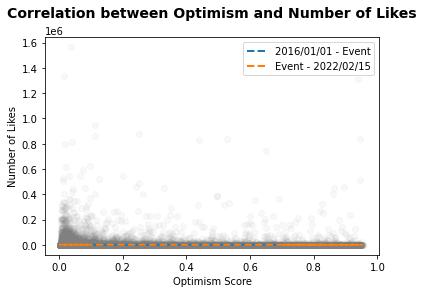

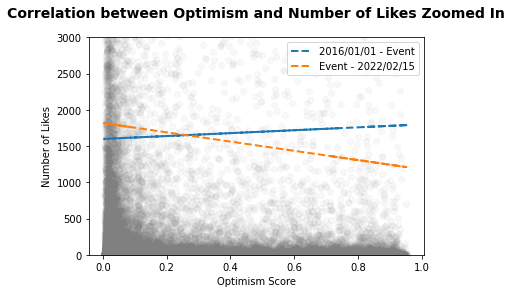

In [ ]:
# plot average optimism score with low alpha value
plt.scatter(df['optimism'], df['r_like_num'], c = 'grey', alpha = 0.05)
# linear regression before and after the event
x1 = df['optimism'][35833:98520]
y1 = df['r_like_num'][35833:98520]
m1,b1 = np.polyfit(x1, y1, 1)
plt.plot(x1, m1*x1 + b1,'--', label='2016/01/01 - Event', linewidth=2, c = 'tab:blue')
x2 = df['optimism'][98520:]
y2 = df['r_like_num'][98520:]
m2,b2 = np.polyfit(x2, y2, 1)
plt.plot(x2, m2*x2 + b2,'--', label='Event - 2022/02/15', linewidth=2, c = 'tab:orange')
# plot
plt.xlabel("Optimism Score")
plt.ylabel("Number of Likes")
plt.legend(loc = 'upper right')
plt.title('Correlation between Optimism and Number of Likes',fontweight ='bold',size=14, pad=20)
plt.savefig('optimism_num_like')
plt.show()

# plot average optimism score with low alpha value
plt.ylim((0,3000))
plt.scatter(df['optimism'], df['r_like_num'], c = 'grey', alpha = 0.05)
# linear regression before and after the event
x1 = df['optimism'][35833:98520]
y1 = df['r_like_num'][35833:98520]
m1,b1 = np.polyfit(x1, y1, 1)
plt.plot(x1, m1*x1 + b1,'--', label='2016/01/01 - Event', linewidth=2, c = 'tab:blue')
x2 = df['optimism'][98520:]
y2 = df['r_like_num'][98520:]
m2,b2 = np.polyfit(x2, y2, 1)
plt.plot(x2, m2*x2 + b2,'--', label='Event - 2022/02/15', linewidth=2, c = 'tab:orange')
# plot
plt.xlabel("Optimism Score")
plt.ylabel("Number of Likes")
plt.legend(loc = 'upper right')
plt.title('Correlation between Optimism and Number of Likes Zoomed In',fontweight ='bold',size=14, pad=20)
plt.savefig('optimism_num_like_zoomed_in')
plt.show()

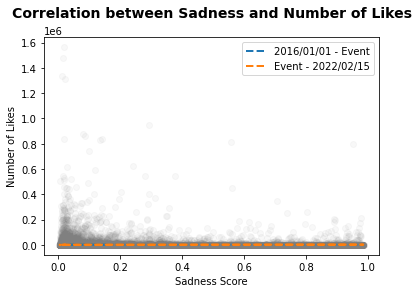

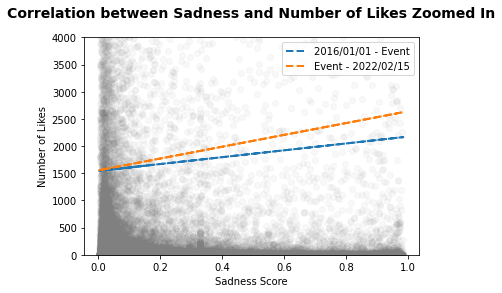

In [ ]:
# plot average sadness score with low alpha value
plt.scatter(df['sadness'], df['r_like_num'], c = 'grey', alpha = 0.05)
# linear regression before and after the event
x1 = df['sadness'][35833:98520]
y1 = df['r_like_num'][35833:98520]
m1,b1 = np.polyfit(x1, y1, 1)
plt.plot(x1, m1*x1 + b1,'--', label='2016/01/01 - Event', linewidth=2, c = 'tab:blue')
x2 = df['sadness'][98520:]
y2 = df['r_like_num'][98520:]
m2,b2 = np.polyfit(x2, y2, 1)
plt.plot(x2, m2*x2 + b2,'--', label='Event - 2022/02/15', linewidth=2, c = 'tab:orange')
# plot
plt.xlabel("Sadness Score")
plt.ylabel("Number of Likes")
plt.legend(loc = 'upper right')
plt.title('Correlation between Sadness and Number of Likes',fontweight ='bold',size=14, pad=20)
plt.savefig('sadness_num_like')
plt.show()

# plot average sadness score with low alpha value
plt.ylim((0,4000))
plt.scatter(df['sadness'], df['r_like_num'], c = 'grey', alpha = 0.05)
# linear regression before and after the event
x1 = df['sadness'][35833:98520]
y1 = df['r_like_num'][35833:98520]
m1,b1 = np.polyfit(x1, y1, 1)
plt.plot(x1, m1*x1 + b1,'--', label='2016/01/01 - Event', linewidth=2, c = 'tab:blue')
x2 = df['sadness'][98520:]
y2 = df['r_like_num'][98520:]
m2,b2 = np.polyfit(x2, y2, 1)
plt.plot(x2, m2*x2 + b2,'--', label='Event - 2022/02/15', linewidth=2, c = 'tab:orange')
# plot
plt.xlabel("Sadness Score")
plt.ylabel("Number of Likes")
plt.legend(loc = 'upper right')
plt.title('Correlation between Sadness and Number of Likes Zoomed In',fontweight ='bold',size=14, pad=20)
plt.savefig('sadness_num_like_zoomed_in')
plt.show()

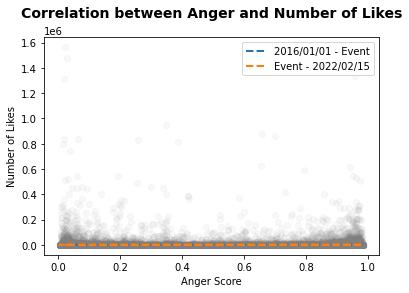

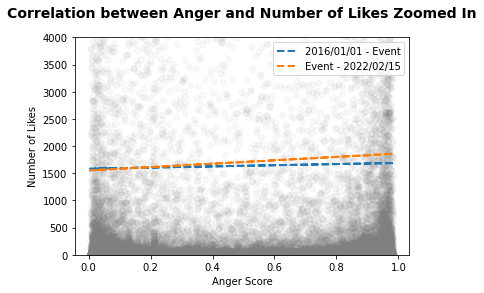

In [ ]:
# plot average anger score with low alpha value
plt.scatter(df['anger'], df['r_like_num'], c = 'grey', alpha = 0.05)
# linear regression before and after the event
x1 = df['anger'][35833:98520]
y1 = df['r_like_num'][35833:98520]
m1,b1 = np.polyfit(x1, y1, 1)
plt.plot(x1, m1*x1 + b1,'--', label='2016/01/01 - Event', linewidth=2, c = 'tab:blue')
x2 = df['anger'][98520:]
y2 = df['r_like_num'][98520:]
m2,b2 = np.polyfit(x2, y2, 1)
plt.plot(x2, m2*x2 + b2,'--', label='Event - 2022/02/15', linewidth=2, c = 'tab:orange')
# plot
plt.xlabel("Anger Score")
plt.ylabel("Number of Likes")
plt.legend(loc = 'upper right')
plt.title('Correlation between Anger and Number of Likes',fontweight ='bold',size=14, pad=20)
plt.savefig('anger_num_like')
plt.show()

# plot average anger score with low alpha value
plt.ylim((0,4000))
plt.scatter(df['anger'], df['r_like_num'], c = 'grey', alpha = 0.05)
# linear regression before and after the event
x1 = df['anger'][35833:98520]
y1 = df['r_like_num'][35833:98520]
m1,b1 = np.polyfit(x1, y1, 1)
plt.plot(x1, m1*x1 + b1,'--', label='2016/01/01 - Event', linewidth=2, c = 'tab:blue')
x2 = df['anger'][98520:]
y2 = df['r_like_num'][98520:]
m2,b2 = np.polyfit(x2, y2, 1)
plt.plot(x2, m2*x2 + b2,'--', label='Event - 2022/02/15', linewidth=2, c = 'tab:orange')
# plot
plt.xlabel("Anger Score")
plt.ylabel("Number of Likes")
plt.legend(loc = 'upper right')
plt.title('Correlation between Anger and Number of Likes Zoomed In',fontweight ='bold',size=14, pad=20)
plt.savefig('anger_num_like_zoomed_in')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X = x1
y = y1

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             r_like_num   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3055
Date:                Thu, 02 Jun 2022   Prob (F-statistic):              0.580
Time:                        01:53:36   Log-Likelihood:            -7.0372e+05
No. Observations:               62687   AIC:                         1.407e+06
Df Residuals:                   62685   BIC:                         1.407e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1584.2914    119.286     13.281      0.0